In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv



# Titanic EDA to Predict
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#ml">Applying Several ML Algorithms</a></li>
<li><a href="#conclusion">Conclusion and Final Comments</a></li>

</ul>

<a id='intro'></a>
## Introduction



>The sinking of the Titanic is one of the most infamous shipwrecks in history.
>On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

> ### Data Dictionary

>1. survival = Survival / 0 = No, 1 = Yes
2. pclass = Ticket class / 1 = 1st, 2 = 2nd, 3 = 3rd
3. sex = Sex 	
4. Age = Age in years 	
5. sibsp = of siblings / spouses aboard the Titanic 	
6. parch = of parents / children aboard the Titanic 	
7. ticket = Ticket number 	
8. fare = Passenger fare 	
9. cabin = Cabin number 	
10. embarked = Port of Embarkation / C = Cherbourg, Q = Queenstown, S = Southampton

> ### Variable Notes

>pclass: A proxy for socio-economic status (SES)
/1st = Upper
/2nd = Middle
/3rd = Lower

>age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

>sibsp: The dataset defines family relations in this way...
/Sibling = brother, sister, stepbrother, stepsister
/Spouse = husband, wife (mistresses and fiancés were ignored)

>parch: The dataset defines family relations in this way...
/Parent = mother, father
/Child = daughter, son, stepdaughter, stepson
/Some children travelled only with a nanny, therefore parch=0 for them.


### Which questions will we find answers in the Exploratory Data Analysis section?

> 1. What is the number of survivors and non-survivors among those who boarded from which port by gender and in what class?
>
> 2. What are the Passengers' survival percentages by class and gender?
>
> 3. What are the number  of survived/drowned passengers  by age and gender?
>
> 4. What are the Passengers' survival/drowned distribution for passengers with parents / children on board?
> 
> 5. What is the proportion of survivors and non-survivors among siblings and spouse(except mistresses and fiancés )?
>


<a id='wrangling'></a>
## Data Wrangling

> After uploading the data, We will perform the clearing, deleting, editing and explore operations in this section in order to get it ready for analysis. Therefore, We need some important libraries which are has been imported at below.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
from scipy import interpolate
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
import time
from statistics import mean
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn import model_selection

In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")

In [4]:
# take look our data frame
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# let's look from bottom
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [6]:
#Check data type
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

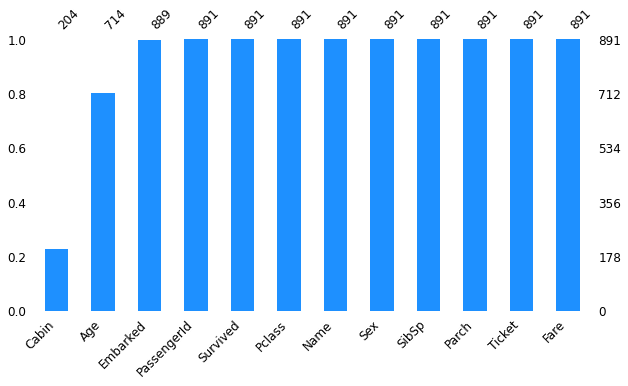

In [7]:
msno.bar(train_df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12)

In [8]:
#let's look at list if sum of null values
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

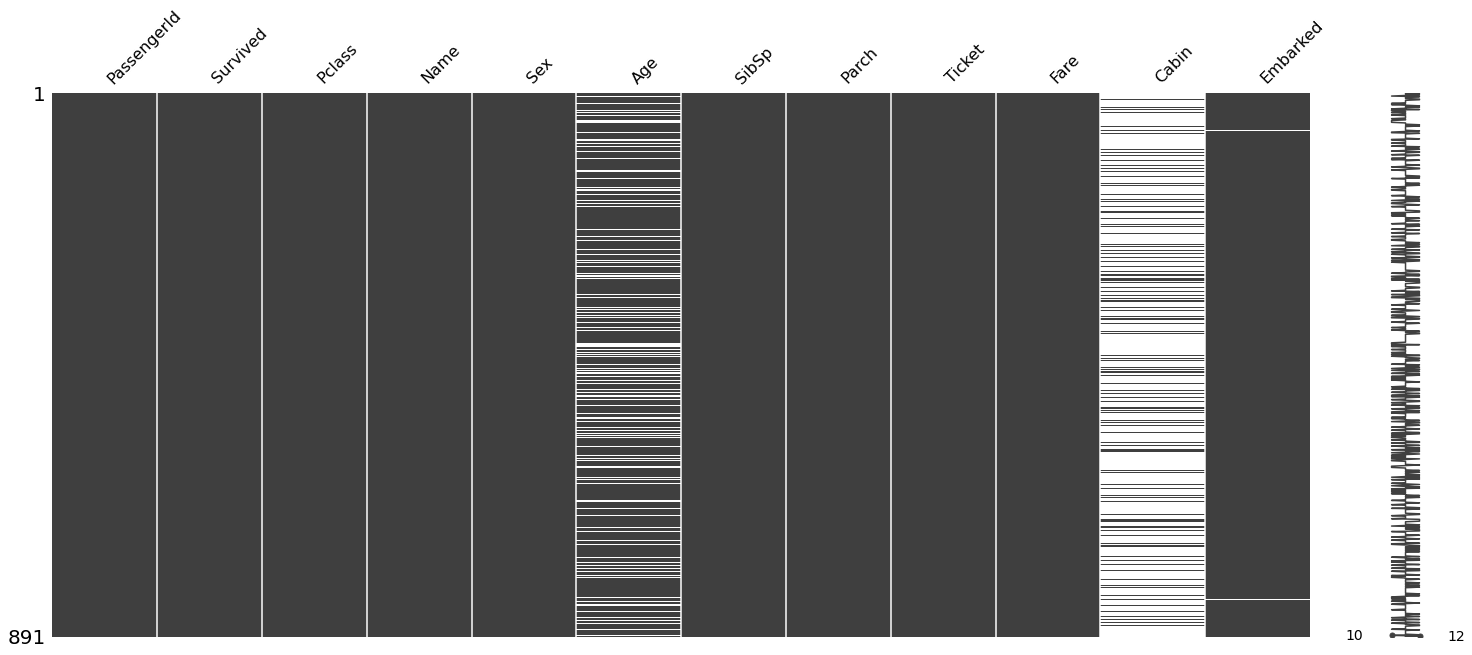

In [9]:
# we can look at our missing value with matris that is provide us to understand those missing values are rondom or not
msno.matrix(train_df)


In [10]:
# Before the look correlations for missing values we should convert the a few columns that are not numerical and might have more corretion with missings.

train_df['Sex'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)


train_df.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [11]:
#Let's look at correlation between ages.
train_df.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333
Age,0.036847,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000


### Final Decide for Missing Values
#### Embarked :
> Looking at the two missing values for 'Embarked', we can see that the passengers traveled together, as they have the same ticket number. We then look at the price they have paid for the ticket and compare it with a range of passengers who paid a similar fee and traveled in the same class. From those passengers, we calculate the mode and use this value as our two missing Embarked values.
#### Age : 
> This could be a case of MAR(Missing at random) as we cannot directly observe the reason for missingness of data in these columns. We should fill them. There are various approach to fill it. We will figure out this missing values with find median of combination with columns(Gender and Class) which have more correlation between age column.
#### Cabin : 
>There are a lot of missing in this column we are not going to use in our analyze therefore,we can drop that column.


In [12]:
# Filling of Embarked Column
train_df[train_df['Embarked'].isna()] #Passengers travelling together

sub_embarked = train_df[(train_df['Fare'] > 79) & (train_df['Fare'] < 81) & (train_df['Pclass'] == 1)]
fill_mode = sub_embarked["Embarked"].mode()[0]


train_df = train_df.fillna({'Embarked': fill_mode})

In [13]:
# Drop cabin column
train_df = train_df.drop(['Cabin'], axis=1)
# Also we can drop ticket column now because we will not use future analyza and predict.
train_df = train_df.drop(["Ticket"], axis=1)

In [14]:
# Let's create one matrix for guess based on Sex and Pclass column.
ags = np.zeros((2,3))
ags

array([[0., 0., 0.],
       [0., 0., 0.]])

In [15]:
# We created function we will use also test data in Applying Several ML Algorithms section.
def find_ages(df):
    for i in range(0, 2):
        for j in range(0, 3):
            g_df = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna()


            guess = g_df.median()

            # Convert random age float to nearest .5 age
            ags[i,j] = int( guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[ (df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1),'Age'] = ags[i,j]

    df['Age'] = df['Age'].astype(int)


In [16]:
#Call function with train data set
find_ages(train_df)

In [17]:
# Check to missing values again
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    int64  
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
dtypes: float64(1), int64(7), object(2)
memory usage: 69.7+ KB


<a id='eda'></a>
## Exploratory Data Analysis

> 
> Now our data is clean and ready to analyze !

### Question 1: What is the number of survivors and non-survivors among those who boarded from which port by gender and in what class?

In [18]:
pd.crosstab([train_df.Embarked,train_df.Pclass],[train_df.Sex,train_df.Survived],margins=True).style.background_gradient(cmap='summer_r')

#### Question 1 Comment:
>The highest number of women and men who lost their lives are 3rd class passengers at Southampton Embarkation port.
>
>The number of people who lost their lives was in the 3rd class most in total.

### Question 2: What are the Passengers' survival percentages by class and gender?

In [19]:
pd.crosstab([train_df.Sex,train_df.Survived],train_df.Pclass,margins=True).style.background_gradient(cmap='summer_r')

#### Question 4 Comment :
>Almost all the women (% 97) in the 1st class survived.
>
>Although the number of passengers in the 2nd class is less than the number of passengers in the 1st class, the number of survivors in the 1st class is higher.

### Question 3 : Number  of survived/drowned passengers  by age and gender?

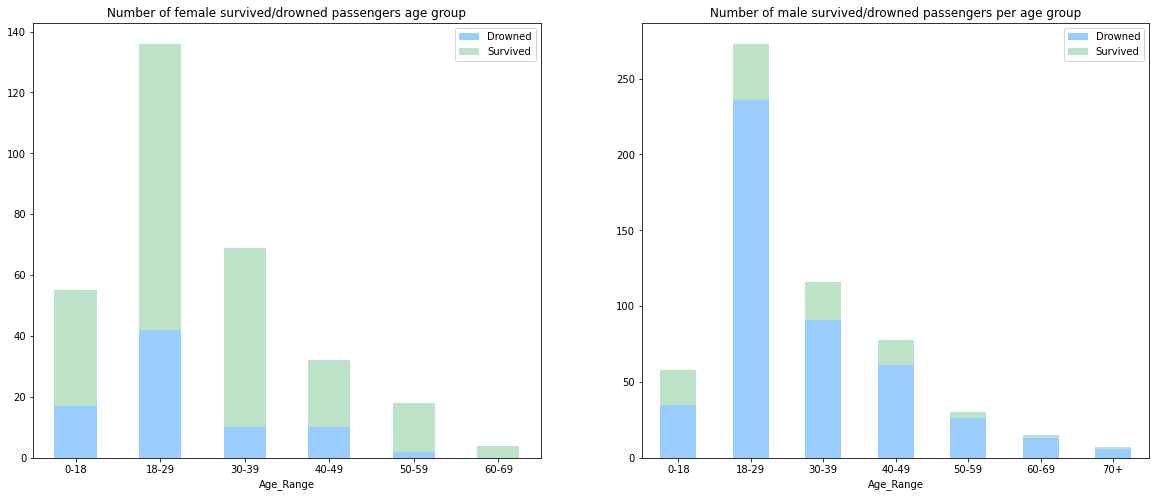

In [20]:
def age_buckets(x): 
    if x < 18: return '0-18' 
    elif x < 30: return '18-29'
    elif x < 40: return '30-39' 
    elif x < 50: return '40-49' 
    elif x < 60: return '50-59' 
    elif x < 70: return '60-69' 
    elif x >=70: return '70+' 
    else: return 'other'
    
    
train_df["Age"] = train_df["Age"].astype(int)

train_df["Age_Range"] = train_df["Age"].apply(lambda x: age_buckets(x))

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))  

grouped_by_age_female = train_df[train_df["Sex"] == 1].groupby(["Age_Range"])["Survived"].value_counts().unstack()
grouped_by_age_female.plot.bar(stacked=True, color=['#99CCFF', '#BCE2C8'], rot=0,ax=ax1, title="Number of female survived/drowned passengers age group")
ax1.legend(('Drowned', 'Survived'))

grouped_by_age_men = train_df[train_df["Sex"] == 0].groupby(["Age_Range"])["Survived"].value_counts().unstack()
grouped_by_age_men.plot.bar(stacked=True, color=['#99CCFF', '#BCE2C8'], rot=0,ax=ax2, title="Number of male survived/drowned passengers per age group")
ax2.legend(('Drowned', 'Survived'))

#### Question 3 Comment:
>We can conclude that the number of female survivors per age group is higher than the number of females per age group that drowned.
>
>When looking at the number of male survivors, we can observe that male passenger were more likely to drown in all age groups.

### Question 4 : What are the Passengers' survival/drowned distribution for passengers with parents / children on board?

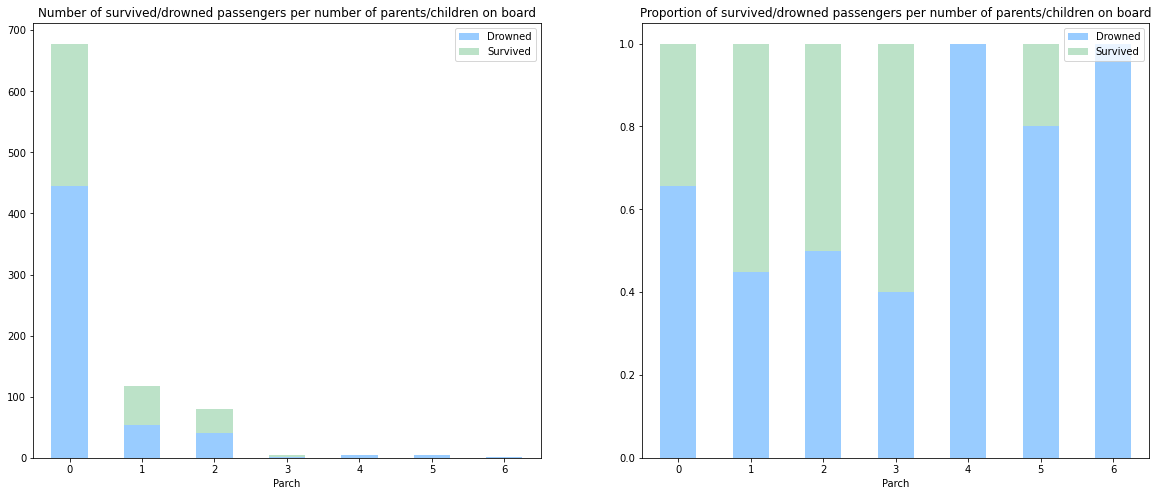

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8)) 

grouped_by_family = train_df.groupby(["Parch"])["Survived"].value_counts()
grouped_by_family.unstack().plot.bar(stacked=True, color=['#99CCFF', '#BCE2C8'], rot=0,ax=ax1, title="Number of survived/drowned passengers per number of parents/children on board")
plt.legend(( 'Drowned', 'Survived'), loc=(1.04,0))
ax1.legend(('Drowned', 'Survived'))

grouped_by_family_norm = train_df.groupby(["Parch"])["Survived"].value_counts(normalize=True)
grouped_by_family_norm.unstack().plot.bar(stacked=True, color=['#99CCFF', '#BCE2C8'], rot=0,ax=ax2, title="Proportion of survived/drowned passengers per number of parents/children on board")
ax2.legend(('Drowned', 'Survived'))

#### Question 4 Comment:
> We can see that the majority of the passengers traveled without children/parents. If traveling with children/parents, the chances of surviving have not been significantly higher.

### Question 5: What is the proportion of survivors and non-survivors among siblings and spouse(except mistresses and fiancés )?

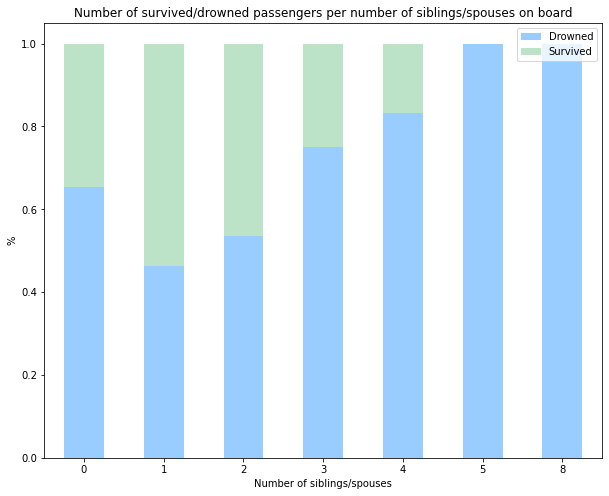

In [22]:
grouped_by_sibsp = train_df.groupby('SibSp')['Survived'].value_counts(normalize=True).unstack()
grouped_by_sibsp.plot(kind='bar', color=["#99CCFF", "#BCE2C8"], stacked=True, rot=0, figsize=(10,8), title="Number of survived/drowned passengers per number of siblings/spouses on board")
plt.legend(( 'Drowned', 'Survived'))

plt.xlabel('Number of siblings/spouses')
plt.ylabel('%')
plt.show()

#### Question 5 Comment:
>We can observe that the percentage of survivors that traveled with siblings/spouses of size 1 and 2 is bigger compared to single travelers. On the contrary when traveling with starting 3 siblings/spouses the percentage of surviving decreases.

### Visualization

In [23]:
#Sex and Embarked columns to check if there's any correlation between them and the Survived data

train_df['Sex_data'] = train_df['Sex'].map({'male': 1,'female': 0})
train_df['Embarked_data'] = train_df['Embarked'].map({'S': 0,'C': 1, 'Q': 2})
train_df.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Sex_data,Embarked_data
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.039529,-0.057527,-0.001652,0.012658,NaN,-0.030444
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.060291,-0.035322,0.081629,0.257307,NaN,0.111203
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.414682,0.083081,0.018443,-0.549500,NaN,0.040138
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.104584,0.114631,0.245489,0.182333,NaN,0.121266
Age,0.039529,-0.060291,-0.414682,-0.104584,1.000000,-0.250248,-0.175708,0.123250,NaN,-0.053629
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.250248,1.000000,0.414838,0.159651,NaN,-0.061591
Parch,-0.001652,0.081629,0.018443,0.245489,-0.175708,0.414838,1.000000,0.216225,NaN,-0.080277
Fare,0.012658,0.257307,-0.549500,0.182333,0.123250,0.159651,0.216225,1.000000,NaN,0.065492
Sex_data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked_data,-0.030444,0.111203,0.040138,0.121266,-0.053629,-0.061591,-0.080277,0.065492,NaN,1.000000


Text(0.5, 1.0, 'Correlation')

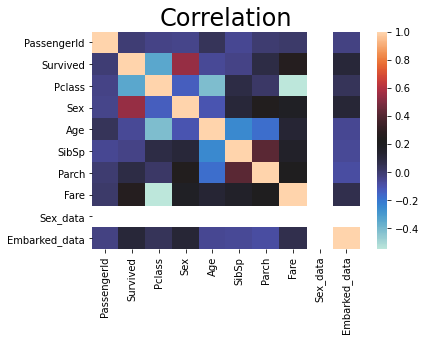

In [24]:
sns.heatmap(train_df.corr(), cmap='icefire')
plt.title('Correlation', fontsize=24)
#In our analysis we see a low correlation between embarked and sex.

In [25]:
#Visualization of 'Survived' (Target column)
train_df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

Text(0, 0.5, 'Passenger Count')

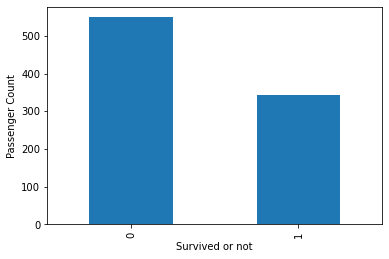

In [26]:
train = train_df.Survived.value_counts().plot(kind='bar')
train.set_xlabel('Survived or not')
train.set_ylabel('Passenger Count')


*Based on the information we have, we can see that only 342 people out of 891 passengers survived on our graph.

Text(0, 0.5, 'Survival Probability')

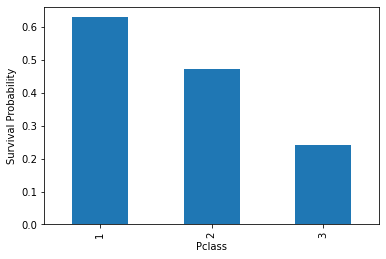

In [27]:
train = train_df[['Pclass', 'Survived']].groupby('Pclass').mean().Survived.plot(kind='bar')
train.set_xlabel('Pclass')
train.set_ylabel('Survival Probability')

*Based on the information we have, we can see that first class has the most survived passengers.

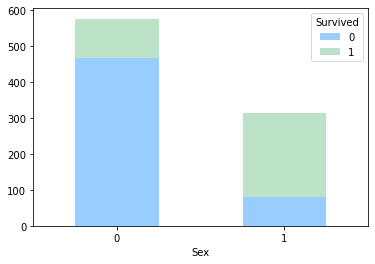

In [28]:
#Survival per Age/Sex
grouped_by_sex = train_df.groupby(["Sex"])["Survived"].value_counts()
grouped_by_sex.unstack().plot.bar(stacked=True, color=['#99CCFF', '#BCE2C8'], rot=0)

> <a id='ml'></a>
## Apply Several ML Algorithms

### Before the start Ml apply we will change the columns into the numerical values. And we will edit test data to get better predict.

In [29]:
# Let's read Test Data and look our train data that we edited in EDA section.
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [30]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Range,Sex_data,Embarked_data
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7.2500,S,18-29,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71.2833,C,30-39,NaN,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,S,18-29,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,S,30-39,NaN,0
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,S,30-39,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27,0,0,13.0000,S,18-29,NaN,0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19,0,0,30.0000,S,18-29,NaN,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,21,1,2,23.4500,S,18-29,NaN,0
889,890,1,1,"Behr, Mr. Karl Howell",0,26,0,0,30.0000,C,18-29,NaN,1


In [31]:
# Delete some columns that are we will not use
train_df = train_df.drop(['Sex_data'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)

In [32]:
# Let's look at missings columns for test data 
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         417 non-null    float64
 8   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 29.5+ KB


In [33]:
# Call our function to fill age column as the same way
test_df['Sex'] = test_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
find_ages(test_df)

In [34]:
# Get the null value line to know which class that passenger have.
test_df[test_df.isna().any(axis=1)].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",0,60,0,0,NaN,S


In [35]:
# Fill fare column that we had one missing value.
df_new = test_df[test_df["Pclass"] == 3]
fare_median = df_new["Fare"].median()

test_df["Fare"] = test_df["Fare"].fillna(fare_median) 

In [36]:
# Look at null value as we can see we handled it.
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          418 non-null    int64  
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         418 non-null    float64
 8   Embarked     418 non-null    object 
dtypes: float64(1), int64(6), object(2)
memory usage: 29.5+ KB


In [37]:
# Add to title columns it will effect our model
def add_title(df):
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

add_title(train_df)
add_title(test_df)


In [38]:
# Make numerical value for title 
def num_title(df):
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna(0)

num_title(train_df)
num_title(test_df)

In [39]:
#Let's look at corr between title and survived
train_df.corr()

# As we can see there is too much corr with it.


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_data,Title
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.039529,-0.057527,-0.001652,0.012658,-0.030444,0.003878
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.060291,-0.035322,0.081629,0.257307,0.111203,0.407753
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.414682,0.083081,0.018443,-0.549500,0.040138,-0.173929
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.104584,0.114631,0.245489,0.182333,0.121266,0.502713
Age,0.039529,-0.060291,-0.414682,-0.104584,1.000000,-0.250248,-0.175708,0.123250,-0.053629,-0.093425
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.250248,1.000000,0.414838,0.159651,-0.061591,0.269623
Parch,-0.001652,0.081629,0.018443,0.245489,-0.175708,0.414838,1.000000,0.216225,-0.080277,0.315784
Fare,0.012658,0.257307,-0.549500,0.182333,0.123250,0.159651,0.216225,1.000000,0.065492,0.136310
Embarked_data,-0.030444,0.111203,0.040138,0.121266,-0.053629,-0.061591,-0.080277,0.065492,1.000000,0.048012
Title,0.003878,0.407753,-0.173929,0.502713,-0.093425,0.269623,0.315784,0.136310,0.048012,1.000000


In [40]:
# Now we can delete name column
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [41]:
# We should creat age band get better predict.

def age_range(df):
    df.loc[ df['Age'] <= 16, 'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[ df['Age'] > 64, 'Age']

age_range(train_df)
age_range(test_df)
train_df = train_df.drop(['Age_Range'], axis=1)


In [42]:
train_df.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Embarked_data,Title
0,1,0,3,0,1,1,0,7.2500,S,0,1
1,2,1,1,1,2,1,0,71.2833,C,1,3
2,3,1,3,1,1,0,0,7.9250,S,0,2
3,4,1,1,1,2,1,0,53.1000,S,0,3
4,5,0,3,0,2,0,0,8.0500,S,0,1


In [43]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,0,2,0,0,7.8292,Q,1
1,893,3,1,2,1,0,7.0000,S,3
2,894,2,0,3,0,0,9.6875,Q,1
3,895,3,0,1,0,0,8.6625,S,1
4,896,3,1,1,1,1,12.2875,S,3


In [44]:
# We are preparing our both data to apply ML models.
train_df = train_df.drop(["Embarked"], axis=1)

In [45]:
# Let's make embarked numerical value for test data set
test_df['Embarked_data'] = test_df['Embarked'].map({'S': 0,'C': 1, 'Q': 2})

In [46]:
test_df = test_df.drop(["Embarked"], axis=1)

In [47]:
# We also do not need passengerid in train data for predict 
train_df = train_df.drop(["PassengerId"], axis=1)


In [48]:
# We can create fareband before to create range we sholud look how many band we can create?
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)
# I tried to 4,5,6 ranges but after for survived rate near to similar to others so we should choose 4 bands.

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [49]:
# We wrote function that create new
def create_fare(df):
    df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df.loc[ df['Fare'] > 31, 'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)

create_fare(train_df)
create_fare(test_df)
train_df = train_df.drop(['FareBand'], axis=1)

    
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_data,Title
0,0,3,0,1,1,0,0,0,1
1,1,1,1,2,1,0,3,1,3
2,1,3,1,1,0,0,1,0,2
3,1,1,1,2,1,0,3,0,3
4,0,3,0,2,0,0,1,0,1
5,0,3,0,1,0,0,1,2,1
6,0,1,0,3,0,0,3,0,1
7,0,3,0,0,3,1,2,0,4
8,1,3,1,1,0,2,1,0,3
9,1,2,1,0,1,0,2,1,3


In [50]:
train_df.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_data,Title
Survived,1.000000,-0.338481,0.543351,-0.065095,-0.035322,0.081629,0.295875,0.111203,0.407753
Pclass,-0.338481,1.000000,-0.131900,-0.119955,0.083081,0.018443,-0.628459,0.040138,-0.173929
Sex,0.543351,-0.131900,1.000000,-0.086719,0.114631,0.245489,0.248940,0.121266,0.502713
Age,-0.065095,-0.119955,-0.086719,1.000000,-0.066396,-0.043457,0.026774,0.038205,-0.042927
SibSp,-0.035322,0.083081,0.114631,-0.066396,1.000000,0.414838,0.394248,-0.061591,0.269623
Parch,0.081629,0.018443,0.245489,-0.043457,0.414838,1.000000,0.393048,-0.080277,0.315784
Fare,0.295875,-0.628459,0.248940,0.026774,0.394248,0.393048,1.000000,-0.086303,0.341665
Embarked_data,0.111203,0.040138,0.121266,0.038205,-0.061591,-0.080277,-0.086303,1.000000,0.048012
Title,0.407753,-0.173929,0.502713,-0.042927,0.269623,0.315784,0.341665,0.048012,1.000000


In [51]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Embarked_data
0,892,3,0,2,0,0,0,1,2
1,893,3,1,2,1,0,0,3,0
2,894,2,0,3,0,0,1,1,2
3,895,3,0,1,0,0,1,1,0
4,896,3,1,1,1,1,1,3,0


In [52]:
X = train_df.drop("Survived", axis=1)
Y = train_df["Survived"]

## Starting ML modeling 

#### We will now start by splitting our dataset into our training (80%) and validation dataset (20%)

In [53]:

X_tr, X_ts, Y_tr, Y_ts =  train_test_split(X,Y, test_size=0.2, random_state=1) 
#Feature scaling
sc_X = StandardScaler()
X_tr = pd.DataFrame(sc_X.fit_transform(X_tr),columns = X_tr.columns)
X_ts = pd.DataFrame(sc_X.fit_transform(X_ts),columns = X_ts.columns)


### KNN

In [54]:
# To find the best value for K we iterated through the range 1 to 40 
# We choose K = 3 that gave us the highest accuracy.
list_neighbors = {}

for i in range(1,40):

    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_tr, Y_tr)
    accuracy_knn = round(knn.score(X_tr, Y_tr) * 100, 2)
    list_neighbors[i] = accuracy_knn
    
    
max_key = max(list_neighbors, key=list_neighbors.get)
all_values = list_neighbors.values()
max_value_knn = max(all_values)
Y_pred_knn = knn.predict(X_ts)
print("The max accuracy is % " + str(max_value_knn) + " with " + str(max_key) + " neighbors.")



The max accuracy is % 87.22 with 3 neighbors.


Text(0.5, 1.0, 'Accuracy vs K-value')

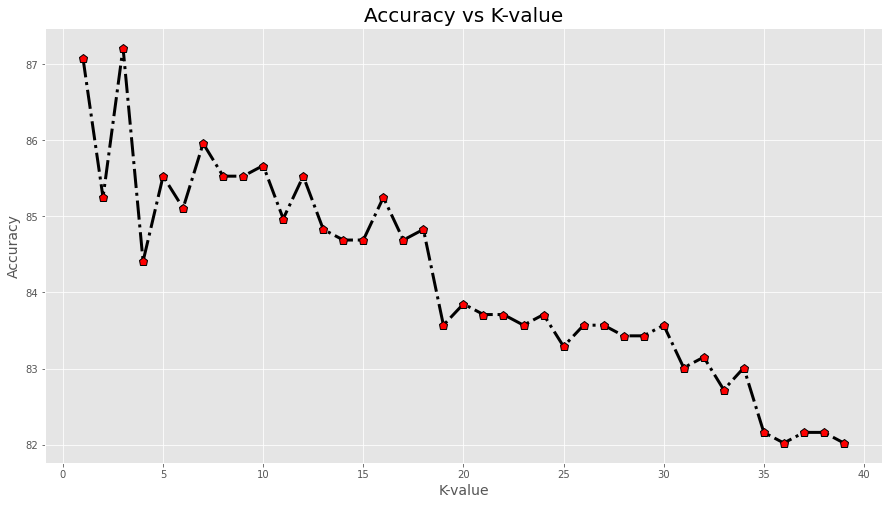

In [55]:
# Plot accuracy according to K-values.
plt.style.use('ggplot')
plt.subplots(figsize = (15,8))
accuracies = []
for k in range(1,40):
    accuracies.append(list_neighbors[k])
plt.plot(range(1,40), accuracies , linewidth=3 , linestyle = 'dashdot', color = 'black', marker = 'p',markersize=9, markerfacecolor = 'red')

plt.xlabel('K-value',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Accuracy vs K-value', fontsize=20)

### Logistic Regression

In [56]:
# Calculating the accuracy score of our training dataset by using the Logistic regression Model.
logreg = LogisticRegression()
logreg.fit(X_tr, Y_tr)
accuracy_log = round(logreg.score(X_tr, Y_tr) * 100, 2)
Y_pred_logreg = logreg.predict(X_ts)
print("The accuracy is: " + str(accuracy_log))

The accuracy is: 80.62


### Linear Discriminant Analysis

In [57]:
# Calculating the accuracy score of our training dataset by using the Logistic regression Model.
lda = LinearDiscriminantAnalysis()
lda.fit(X_tr, Y_tr)
accuracy_lda = round(lda.score(X_tr, Y_tr) * 100, 2)
Y_pred_lda = lda.predict(X_ts)
print("The accuracy is: " + str(accuracy_lda))


The accuracy is: 80.48


#### Compering ML Models

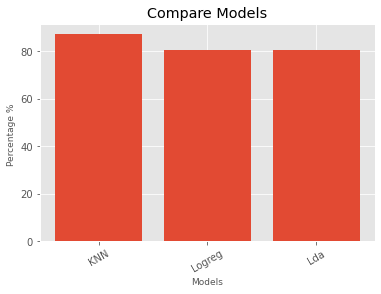

In [58]:
# We used plot-bar to see compare different obtain accuracy.
label = ['KNN','Logreg','Lda']
list_accuracy = [max_value_knn,accuracy_log,accuracy_lda]
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, list_accuracy)
    plt.xlabel('Models', fontsize=9)
    plt.ylabel('Percentage % ', fontsize=9)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title('Compare Models')
    plt.show()
    
plot_bar_x()

In [59]:
# Confusion Matrix
def conf_mat(Y_predict,model_name):
    ax = plt.axes()
    cf = pd.crosstab(Y_ts, Y_predict, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(cf, annot=True)
    ax.set_title(str(model_name)+' Confusion Matrix')
    plt.show()


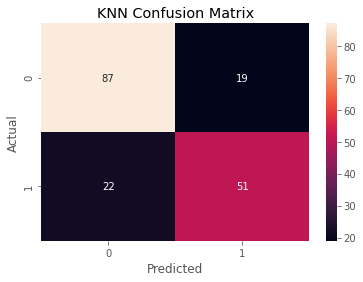

In [60]:
conf_mat(Y_pred_knn,"KNN")

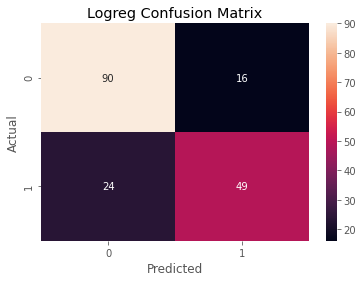

In [61]:
conf_mat(Y_pred_logreg,"Logreg")

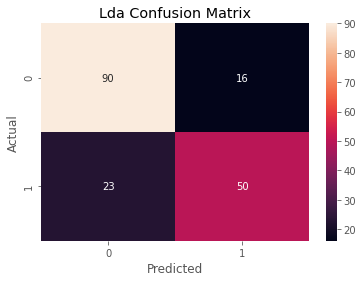

In [62]:
conf_mat(Y_pred_lda,"Lda")

> We will now compare the accuracy score of our training and validation dataset on the KNN, Logereg and lda Model 

In [63]:
list_neighbors_train = {}
list_neighbors_val = {}

for i in range(1,40):

    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_tr, Y_tr)
    
    #IMPORATNT training and validation data
    y_pred_knn_train = knn.predict(X_tr)
    accuracy_knn_train = accuracy_score(Y_tr,y_pred_knn_train)
    
    y_pred_knn_val = knn.predict(X_ts)
    accuracy_knn_val = accuracy_score(Y_ts,y_pred_knn_val)
        
    #accuracy_knn = round(knn.score(X_tr, Y_tr) * 100, 2)
    list_neighbors_train[i] = accuracy_knn_train
    list_neighbors_val[i] = accuracy_knn_val
    
    
max_key_train = max(list_neighbors_train, key=list_neighbors_train.get)
all_values_train = list_neighbors_train.values()
max_value_knn_train = max(all_values_train)
print("The max training accuracy is % " + str(max_value_knn_train) + " with " + str(max_key_train) + " neighbors.")

max_key_val = max(list_neighbors_val, key=list_neighbors_val.get)
all_values_val = list_neighbors_val.values()
max_value_knn_val = max(all_values_val)
print("The max validation accuracy is % " + str(max_value_knn_val) + " with " + str(max_key_val) + " neighbors.")

The max training accuracy is % 0.8721910112359551 with 3 neighbors.
The max validation accuracy is % 0.7988826815642458 with 5 neighbors.


In [64]:
logreg = LogisticRegression()
logreg.fit(X_tr, Y_tr)

#IMPORATNT training and testing data
y_pred_logreg_train = logreg.predict(X_tr)
accuracy_logreg_train = accuracy_score(Y_tr,y_pred_logreg_train)

y_pred_logreg_val = logreg.predict(X_ts)
accuracy_logreg_val = accuracy_score(Y_ts,y_pred_logreg_val)
    
print("The training accuracy is % " + str(accuracy_logreg_train))
print("The validation accuracy is % " + str(accuracy_logreg_val))

The training accuracy is % 0.8061797752808989
The validation accuracy is % 0.776536312849162


In [65]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_tr, Y_tr)

#IMPORATNT training and testing data
y_pred_lda_train = lda.predict(X_tr)
accuracy_lda_train = accuracy_score(Y_tr,y_pred_lda_train)

y_pred_lda_val = lda.predict(X_ts)
accuracy_lda_val = accuracy_score(Y_ts,y_pred_lda_val)
    
print("The training accuracy is % " + str(accuracy_lda_train))
print("The validation accuracy is % " + str(accuracy_lda_val))

The training accuracy is % 0.8047752808988764
The validation accuracy is % 0.7821229050279329


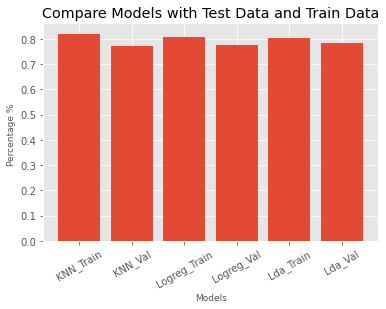

In [66]:
label = ['KNN_Train','KNN_Val','Logreg_Train','Logreg_Val','Lda_Train','Lda_Val']
list_accuracy = [accuracy_knn_train,accuracy_knn_val,accuracy_logreg_train,accuracy_logreg_val,accuracy_lda_train,accuracy_lda_val]
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, list_accuracy)
    plt.xlabel('Models', fontsize=9)
    plt.ylabel('Percentage % ', fontsize=9)
    plt.xticks(index, label, fontsize=10, rotation=30)
    plt.title('Compare Models with Test Data and Train Data')
    plt.show()
    
plot_bar_x()

### Now we will take diffrent sample size from train data set to look our effects of sample.


In [67]:
# We changed size of test from %10 to %90 and we got accuracies for each diffrent sample size.
knn_accs=[]
log_accs=[]
lda_accs=[]
for j in range(9):
    size = (j+1)/10
    X_tr, X_ts, Y_tr, Y_ts =  train_test_split(X,Y, test_size=size, random_state=1) 
    #Feature scaling
    sc_X = StandardScaler()
    X_tr = pd.DataFrame(sc_X.fit_transform(X_tr),columns = X_tr.columns)
    X_ts = pd.DataFrame(sc_X.fit_transform(X_ts),columns = X_ts.columns)
    #Knn
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_tr, Y_tr)
    Y_pred_knn = knn.predict(X_ts)
    accuracy_knn = round(knn.score(X_tr, Y_tr) * 100, 2)
    knn_accs.append(accuracy_knn)
    print("Sample size of test for KNN  :" + str(size)+ ", Accuracy is : " + str(accuracy_knn)  )
    #Logreg
    logreg = LogisticRegression()
    logreg.fit(X_tr, Y_tr)
    Y_pred = logreg.predict(X_ts)
    accuracy_log = round(logreg.score(X_tr, Y_tr) * 100, 2)
    log_accs.append(accuracy_log)
    print("Sample size of test for Log  :" + str(size)+ ", Accuracy is : " + str(accuracy_log)  )
    #Lda
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_tr, Y_tr)
    Y_pred = lda.predict(X_ts)
    accuracy_lda= round(lda.score(X_tr, Y_tr) * 100, 2)
    lda_accs.append(accuracy_lda)
    print("Sample size of test for Lda  :" + str(size)+ ", Accuracy is : " + str(accuracy_lda)  )

Sample size of test for KNN  :0.1, Accuracy is : 85.14
Sample size of test for Log  :0.1, Accuracy is : 80.52
Sample size of test for Lda  :0.1, Accuracy is : 80.15
Sample size of test for KNN  :0.2, Accuracy is : 87.22
Sample size of test for Log  :0.2, Accuracy is : 80.62
Sample size of test for Lda  :0.2, Accuracy is : 80.48
Sample size of test for KNN  :0.3, Accuracy is : 85.23
Sample size of test for Log  :0.3, Accuracy is : 81.54
Sample size of test for Lda  :0.3, Accuracy is : 80.9
Sample size of test for KNN  :0.4, Accuracy is : 88.01
Sample size of test for Log  :0.4, Accuracy is : 82.4
Sample size of test for Lda  :0.4, Accuracy is : 82.02
Sample size of test for KNN  :0.5, Accuracy is : 88.31
Sample size of test for Log  :0.5, Accuracy is : 82.92
Sample size of test for Lda  :0.5, Accuracy is : 82.7
Sample size of test for KNN  :0.6, Accuracy is : 88.76
Sample size of test for Log  :0.6, Accuracy is : 83.71
Sample size of test for Lda  :0.6, Accuracy is : 83.43
Sample size o

In [68]:
# This Function is plotting according to model for to see sample size effects.

def plot_sample(model,accs):
    
    plt.style.use('ggplot')
    plt.subplots(figsize = (15,8))
    sample = [ ]
    for i in range(9):
        sample.append((i+1)/10)

    plt.plot(sample, accs , linewidth=3 , linestyle = 'dashed', color = 'gray', marker = 'D',markersize=9, markerfacecolor = 'blue')
    title = 'Accuracy vs Sample Size on '+ model
    plt.xlabel('Sample Size',fontsize=14)
    plt.ylabel('Accuracy',fontsize=14)
    plt.title(title, fontsize=20)

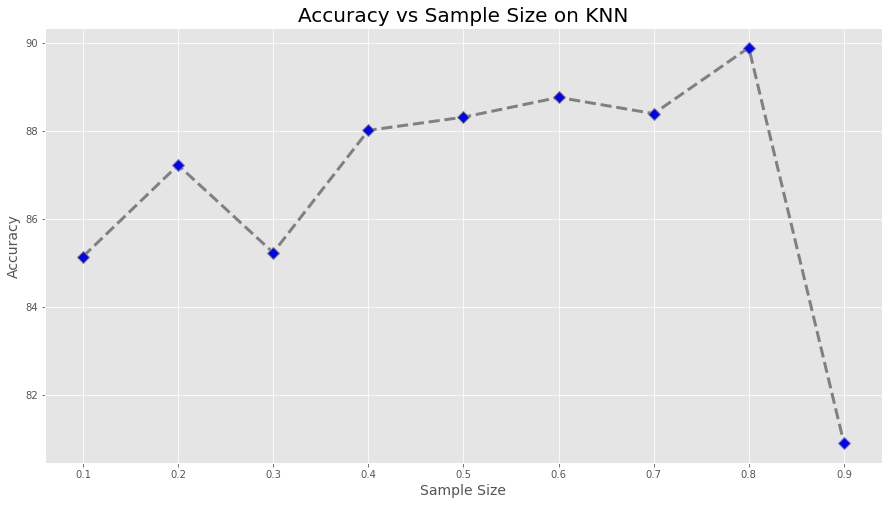

In [69]:
plot_sample("KNN",knn_accs)

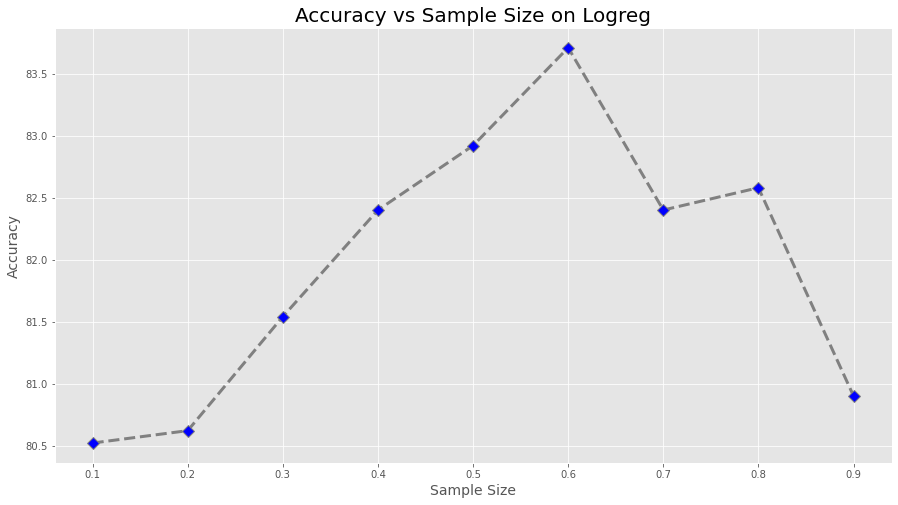

In [70]:
plot_sample("Logreg",log_accs)

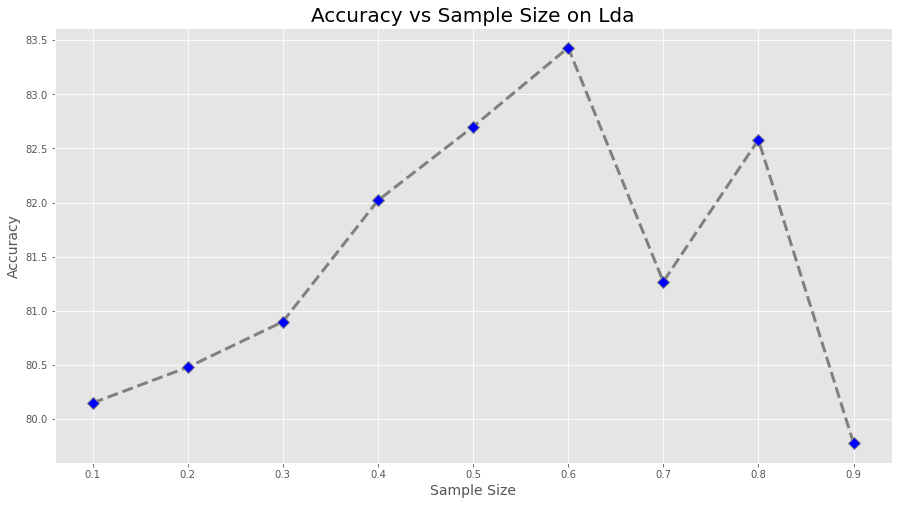

In [71]:
plot_sample("Lda",lda_accs)

### We will now analyze which features are our most relevant indicators.

In [72]:
# We removed survived column to look other features.
columns = []
train_df_new = train_df.copy()
for col in train_df_new.columns: 
    columns.append(col)
columns.pop(0)
columns

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_data', 'Title']

#### Explanation of code in the below
>To find the difference in accuracy, 
>
>We did this calculation: the rate of accuracy we found in the train data - the rate of accuracy we get by dropping each feature.
>
>And so we found the effect of every feature.
>
>We performed for all 3 models.


In [73]:
 
a_knn = {}
a_log = {}
a_lda = {}
for i in columns:
    train_df_1 = train_df.copy()
    i = str(i)
    train_df_1.drop(i, axis=1, inplace=True )
    X = train_df_1.drop("Survived", axis=1)
    Y = train_df_1["Survived"]
    
    X_tr, X_ts, Y_tr, Y_ts =  train_test_split(X,Y, test_size=0.2, random_state=1) 
    #Feature scaling
    sc_X = StandardScaler()
    X_tr = pd.DataFrame(sc_X.fit_transform(X_tr),columns = X_tr.columns)
    X_ts = pd.DataFrame(sc_X.fit_transform(X_ts),columns = X_ts.columns)
    
    #Knn
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_tr, Y_tr)
    accuracy_knn = round(knn.score(X_tr, Y_tr) * 100, 2)
    a_knn[i]=(87.22-accuracy_knn)
    #Logreg
    logreg = LogisticRegression()
    logreg.fit(X_tr, Y_tr)
    accuracy_log = round(logreg.score(X_tr, Y_tr) * 100, 2)
    a_log[i] = (80.62-accuracy_log)
    #Lda
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_tr, Y_tr)
    accuracy_lda= round(lda.score(X_tr, Y_tr) * 100, 2)
    a_lda[i] = (80.48-accuracy_lda)


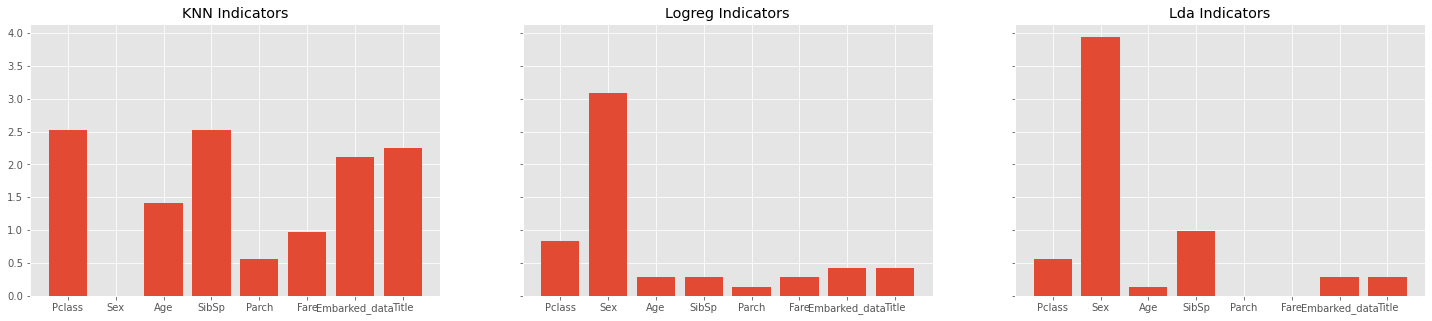

In [74]:
# Ploting accuracy of models with respect to the features.

fig, ((ax1,ax2,ax3)) = plt.subplots(1, 3,figsize=(25, 5), sharex=True, sharey=True)

ax1.bar(a_knn.keys(), a_knn.values())
ax2.bar(a_log.keys(), a_log.values())
ax3.bar(a_lda.keys(), a_lda.values())
ax1.title.set_text('KNN Indicators')
ax2.title.set_text('Logreg Indicators')
ax3.title.set_text('Lda Indicators')

plt.show()

In [75]:
# As we can see at below our indicators are four column: Pclass, Sex, Sibsp, and Title.
# Now we will look at accuracy just with 4 columns.

train_df_2 = train_df.copy()
train_df_2.drop(["Age"], axis=1, inplace=True )
train_df_2.drop(["Parch"], axis=1, inplace=True )
train_df_2.drop(["Fare"], axis=1, inplace=True )
train_df_2.drop(["Embarked_data"], axis=1, inplace=True )
X = train_df_2.drop("Survived", axis=1)
Y = train_df_2["Survived"]
#KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_tr, Y_tr)
Y_pred_knn = knn.predict(X_ts)
accuracy_knn = round(knn.score(X_tr, Y_tr) * 100, 2)
#Logreg
logreg = LogisticRegression()
logreg.fit(X_tr, Y_tr)
Y_pred = logreg.predict(X_ts)
accuracy_log = round(logreg.score(X_tr, Y_tr) * 100, 2)
#Lda
lda = LinearDiscriminantAnalysis()
lda.fit(X_tr, Y_tr)
Y_pred = lda.predict(X_ts)
accuracy_lda= round(lda.score(X_tr, Y_tr) * 100, 2)


print("Knn accuracy score on the train data: " + str(accuracy_knn))
print("Logreg accuracy score on the train data: " + str(accuracy_log))
print("Lda accuracy score on the train data: " + str(accuracy_lda))

Knn accuracy score on the train data: 84.97
Logreg accuracy score on the train data: 80.2
Lda accuracy score on the train data: 80.2


#### Learning Curve
[Learning Curve Wikipedia](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning))
> We can brief here :
>
> A learning curve is a graph that shows the progress on the experience of a particular learning-related metric during the training of a machine learning model. 
>
> So we implement graph for all 3 models.




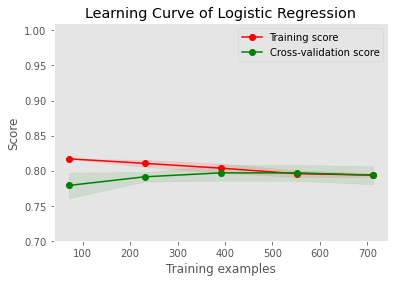

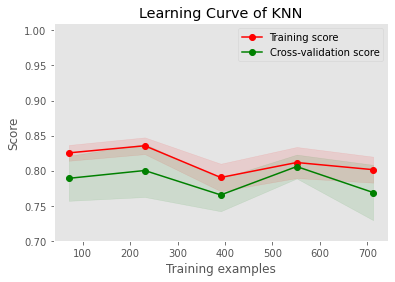

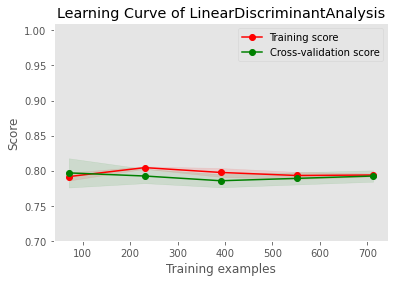

In [76]:

from sklearn.model_selection import learning_curve
def plot_curve(clf,title):

    train_sizes,train_scores,test_scores = learning_curve(clf,X,Y,random_state = 1,cv = 5)

    plt.figure()
    plt.title(title)

    ylim = (0.7, 1.01)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1,
                color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
        label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
        label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

plot_curve(LogisticRegression(),'Learning Curve of Logistic Regression')
plot_curve(KNeighborsClassifier(),'Learning Curve of KNN')
plot_curve(LinearDiscriminantAnalysis(),'Learning Curve of LinearDiscriminantAnalysis')


In [77]:
#Recursive Feature Elimination

from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV

rfe = RFE(estimator=logreg,step=1)
rfe = rfe.fit(X_tr,Y_tr)

selected_rfe_features = pd.DataFrame({'Feature':list(X_tr.columns), 'Ranking': rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')
print(selected_rfe_features)


# Redefine  X and Y RFE
X_train_rfe = rfe.transform(X_tr)
X_test_rfe = rfe.transform(X_ts)


#Logistic Regression RFE
logreg_rfe_model = logreg.fit(X_train_rfe,Y_tr)
accuracy_log_rfe = round(accuracy_score(Y_ts,logreg_rfe_model.predict(X_test_rfe))* 100, 2)
print("Log Accuracy: " +str(accuracy_log_rfe))



#KNN RFE
knn_rfe_model = knn.fit(X_train_rfe,Y_tr)
accuracy_knn_rfe = round(accuracy_score(Y_ts,knn_rfe_model.predict(X_test_rfe))* 100, 2)
print("KNN Accuracy: " +str(accuracy_knn_rfe))


#LDA RFE
lda_rfe_model = lda.fit(X_train_rfe,Y_tr)
accuracy_lda_rfe = round(accuracy_score(Y_ts,lda_rfe_model.predict(X_test_rfe))* 100, 2)
print("LDA Accuracy: " +str(accuracy_lda_rfe))

         Feature  Ranking
0         Pclass        1
1            Sex        1
2            Age        2
3          SibSp        1
4          Parch        5
5           Fare        3
6  Embarked_data        4
Log Accuracy: 78.21
KNN Accuracy: 78.77
LDA Accuracy: 78.21


In [78]:
results = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression','LDA'],
    'Score': [accuracy_knn, accuracy_log, accuracy_lda],
    'Score_rfe': [accuracy_knn_rfe, accuracy_log_rfe, accuracy_lda_rfe]})

results.head(9)

,Model,Score,Score_rfe
0,KNN,84.97,78.77
1,Logistic Regression,80.20,78.21
2,LDA,80.20,78.21


### Now we will apply two additional models for classifaction.Those are Decesion Tree and Naive Bayes.

### Decesion Tree

In [79]:
# Decision Tree
def dtree_scores(dtree):
    dtree.fit(X_tr,Y_tr)
    y_dtree_train_pred = dtree.predict(X_tr)
    y_dtree_test_pred = dtree.predict(X_ts)

    print(f'Train score {accuracy_score(y_dtree_train_pred,Y_tr)}')
    print(f'Test score {accuracy_score(y_dtree_test_pred,Y_ts)}')

    plot_confusionmatrix(y_dtree_train_pred,Y_tr,dom='Train')
    plot_confusionmatrix(y_dtree_test_pred,Y_ts,dom='Test')

In [80]:
# Helper Function Decicion Tree
def plot_decicion_tree(model_tree):
    plt.figure(figsize=(20,20))
    features = list(train_df.drop(['Survived'], axis=1))
    classes = ['Died','Survived']
    tree.plot_tree(model_tree,feature_names=features,class_names=classes,filled=True)
    plt.show()

In [81]:
# Helper Function
def plot_confusionmatrix(y_train_pred,Y_tr,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,Y_tr)
    sns.heatmap(cf,annot=True,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

Train score 0.8960674157303371
Test score 0.6927374301675978
Train Confusion matrix


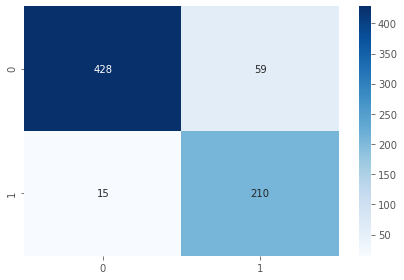

Test Confusion matrix


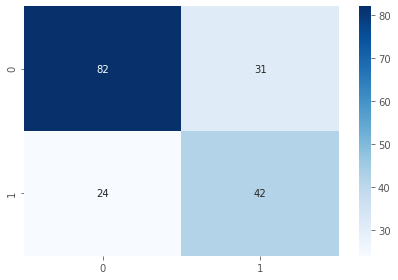

In [82]:
dtree = DecisionTreeClassifier()
dtree_scores(dtree)

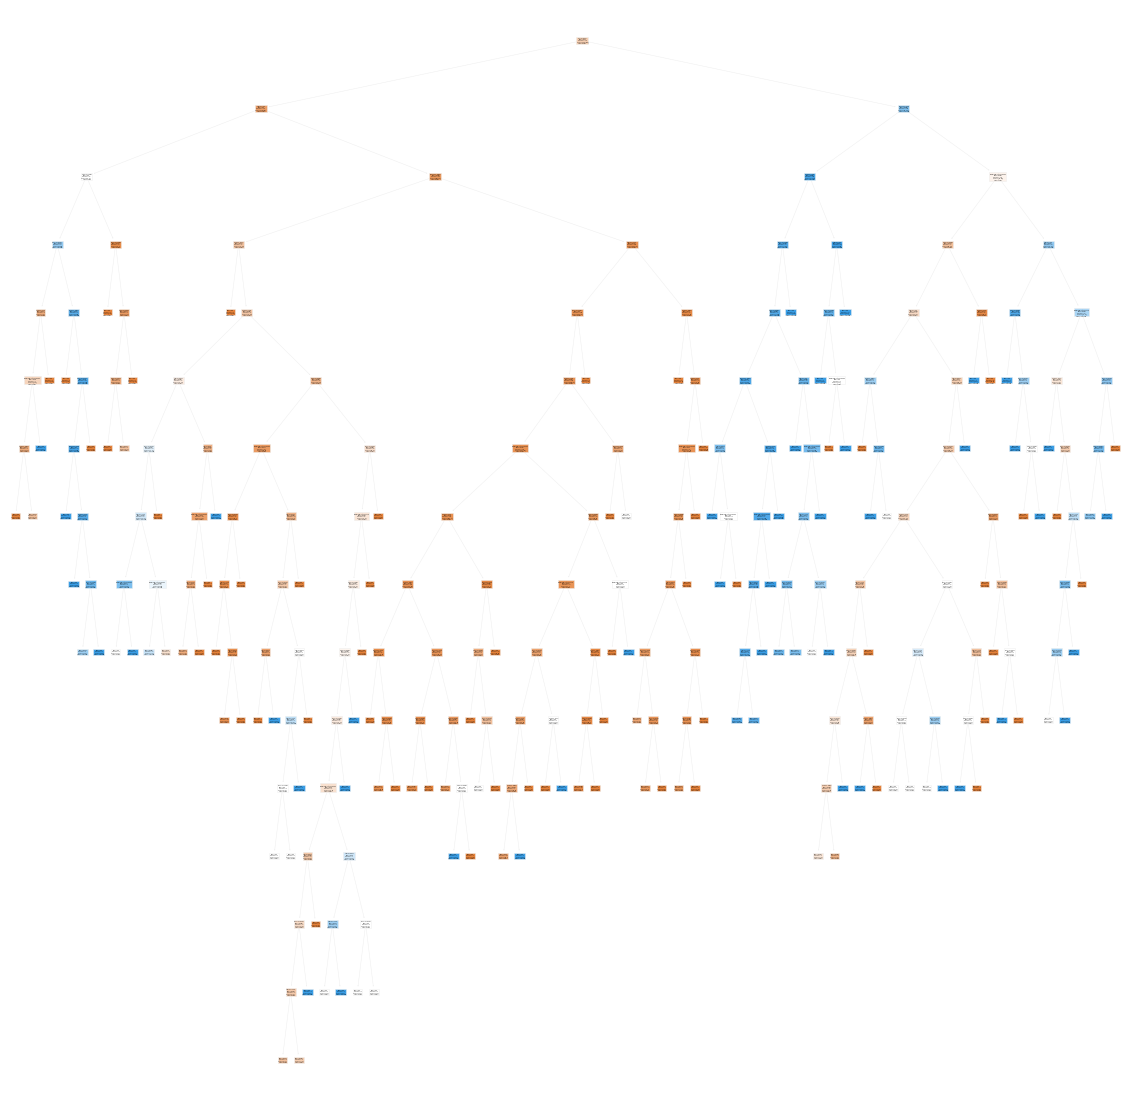

In [83]:
# Plot decision tree
plot_decicion_tree(dtree)

In [84]:
## Decision Tree + Pre-pruning


params = {'max_depth': [2,4,6],   ##maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
         'min_samples_split': [2,3,4,5,6],
         'min_samples_leaf': [1,2,3,4]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
grid_result = gcv.fit(X_tr,Y_tr)
# show best params chosen
best_params = grid_result.best_params_
print(best_params)

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


Train score 0.8426966292134831
Test score 0.7653631284916201
Train Confusion matrix


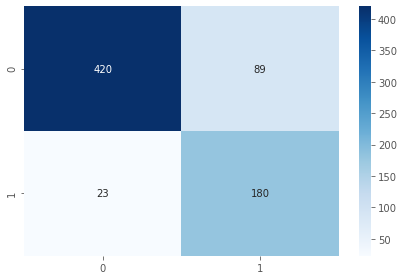

Test Confusion matrix


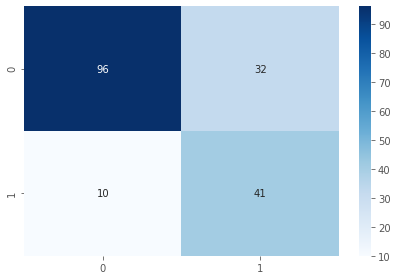

In [85]:
dtree_pre_pruned = gcv.best_estimator_
dtree_scores(dtree_pre_pruned)

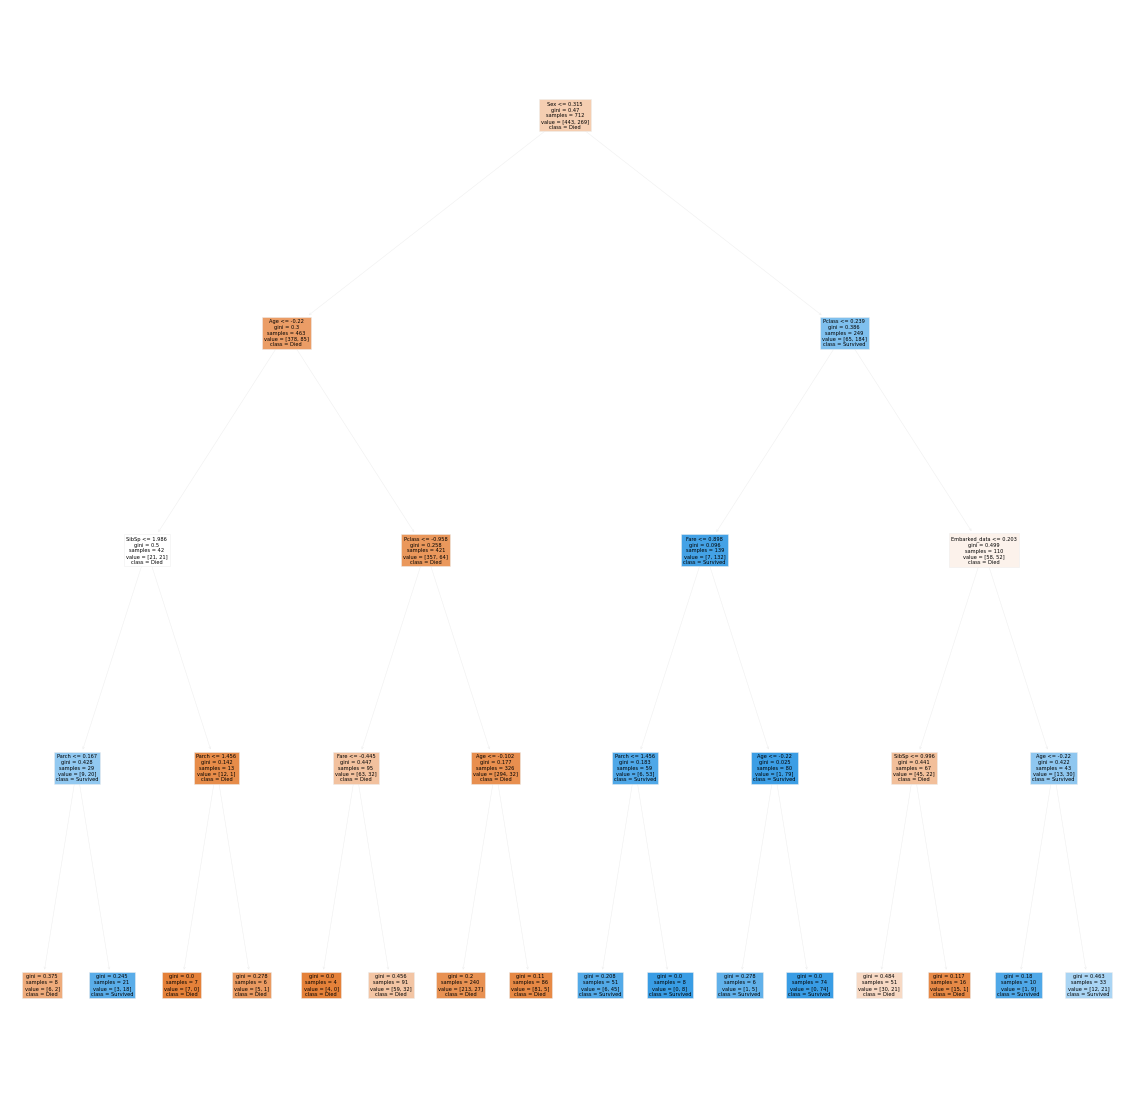

In [86]:
## Plot decision tree pre pruning
plot_decicion_tree(dtree_pre_pruned)

In [87]:
## Cost complexity aka weakest link pruning
path = clf.cost_complexity_pruning_path(X_tr, Y_tr)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 8.21341744e-06
 1.06401090e-05 1.11467808e-05 1.56054931e-05 2.55362615e-05
 3.54819633e-05 3.92865561e-05 4.05142610e-05 4.25604358e-05
 5.35045479e-05 7.80274657e-05 8.36008561e-05 8.91742465e-05
 1.14496825e-04 1.17244748e-04 1.24843945e-04 1.40449438e-04
 1.44908151e-04 1.72595316e-04 2.34082397e-04 2.34082397e-04
 2.36083101e-04 2.52088735e-04 2.62829358e-04 2.78669520e-04
 2.80898876e-04 2.97443046e-04 3.12109863e-04 3.40483487e-04
 3.51123596e-04 3.51123596e-04 3.64628349e-04 4.27725310e-04
 5.60237203e-04 5.61797753e-04 5.83331191e-04 6.07507172e-04
 6.95044656e-04 7.09340597e-04 7.28256346e-04 7.80274657e-04
 8.42696629e-04 8.42696629e-04 8.42696629e-04 8.59998372e-04
 8.63668862e-04 8.83182237e-04 1.05337079e-03 1.20162297e-03
 1.21430243e-03 1.26404494e-03 1.36961152e-03 1.43570537e-03
 1.58340021e-03 1.89374329e-03 1.95122552e-03 2.28098336e-03
 2.63342697e-03 4.17325345e-03 5.99850556e-03 9.46636664e-03
 1.00345364e-02 1.177200

In [88]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_tr, Y_tr)
    clfs.append(clf)

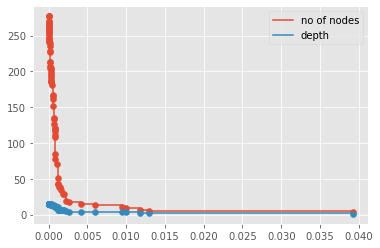

In [89]:
# We will remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

Train score 0.8426966292134831
Test score 0.7653631284916201
Train Confusion matrix


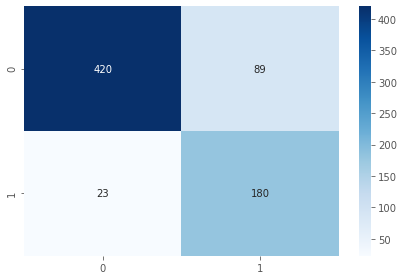

Test Confusion matrix


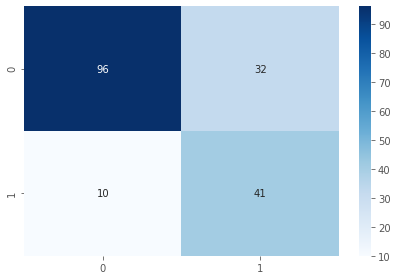

In [90]:
dtree_post_pruned = DecisionTreeClassifier(random_state=0,ccp_alpha=0.005)

dtree_scores(dtree_post_pruned)

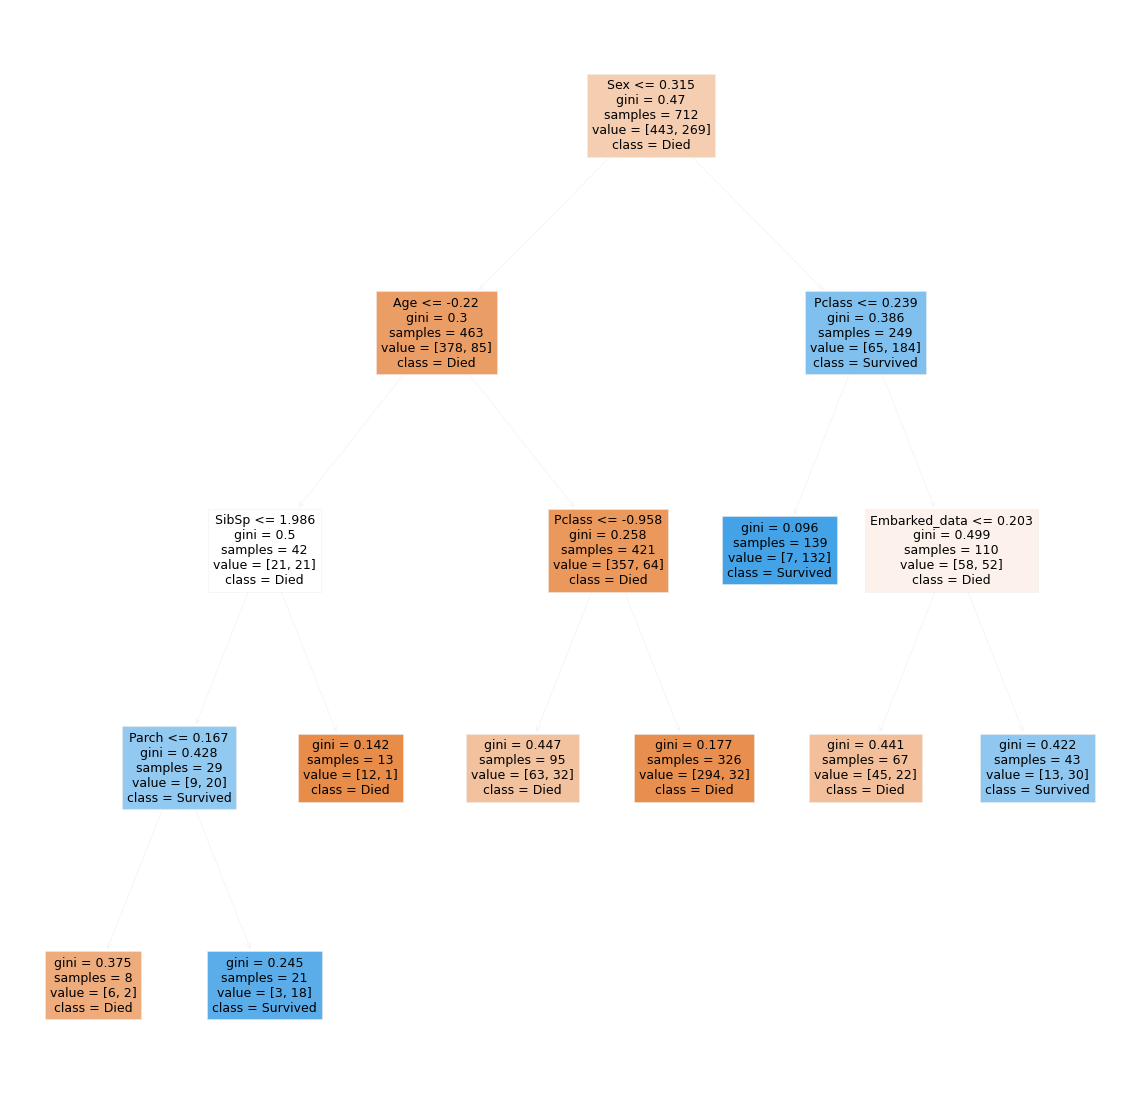

In [91]:
## Plot decision tree post pruning
plot_decicion_tree(dtree_post_pruned)

### Naive Bayes (Gaussian)

> We calculated computing time and accuracy according to sample size with kaggle cpu. 
>
> However,computing time vary based on your device specs.
>
> You should this code with your computer cpu. If possible write your device specs and computing time in comments.

[1.41143798828125e-05, 9.703636169433594e-06, 1.113414764404297e-05, 8.96453857421875e-06, 9.250640869140624e-06, 9.465217590332032e-06, 9.202957153320313e-06, 9.870529174804687e-06, 8.940696716308594e-06]


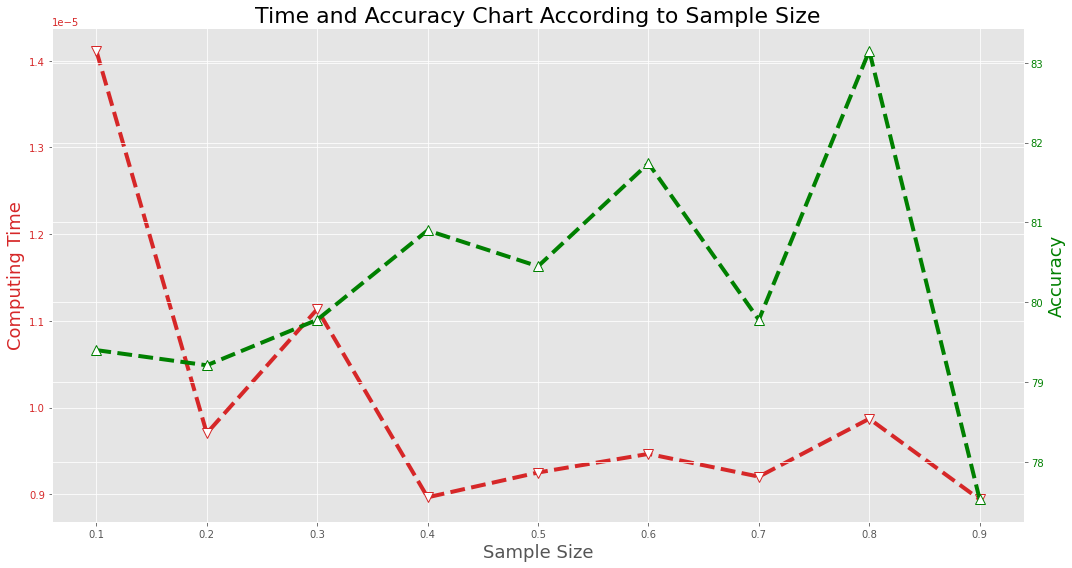

In [92]:

X = train_df.drop("Survived", axis=1)
Y = train_df["Survived"]

def sample_size_time():
    avg_list_time = []
    avg_list_accs = []
    total_time = 0 
    total_accuracy = 0 
    for h in range(9):
        total_accuracy = 0
        total_time = 0 
        for i in range(10):
            size = (h+1)/10
            X_tr, X_ts, Y_tr, Y_ts =  train_test_split(X,Y, test_size=size, random_state=1) 
            sc_X = StandardScaler()
            X_tr = pd.DataFrame(sc_X.fit_transform(X_tr),columns = X_tr.columns)
            X_ts = pd.DataFrame(sc_X.fit_transform(X_ts),columns = X_ts.columns)
            start = time.time()
            gaussian = GaussianNB()
            end = time.time()
            total_time += (end-start)


            gaussian.fit(X_tr, Y_tr)
            Y_pred = gaussian.predict(X_ts)
            accuracy_gaussian = round(gaussian.score(X_tr, Y_tr) * 100, 2)
            total_accuracy +=  accuracy_gaussian

            
        avg_list_time.append((total_time/10))
        avg_list_accs.append(((total_accuracy)/10))

    #Ploting....
    print(avg_list_time)
    fig, ax1 = plt.subplots(figsize = (15,8))
    plt.style.use('ggplot')
    plt.title(' Time and Accuracy Chart According to Sample Size ', fontsize=22)
    sample = [ ]
    for i in range(9):
        sample.append((i+1)/10)
    color = 'tab:red'
    ax1.set_xlabel('Sample Size',fontsize=18)
    ax1.set_ylabel('Computing Time',fontsize=18, color=color)
    ax1.plot(sample, avg_list_time, linewidth=4 , linestyle = 'dashed', color = color, marker = 'v',markersize=10, markerfacecolor = 'white')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


    ax2.set_ylabel('Accuracy', color='green',fontsize=18)  # we already handled the x-label with ax1
    ax2.plot(sample, avg_list_accs ,  linewidth=4 , linestyle = 'dashed', color = 'green', marker = '^',markersize=10, markerfacecolor = 'white')
    ax2.tick_params(axis='y', labelcolor='green')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
sample_size_time()

In [93]:
# Let's get same grapgh with our indicators.<We have already created new df for our indicators>
X = train_df_2.drop("Survived", axis=1)
Y = train_df_2["Survived"]

[1.7905235290527342e-05, 1.3566017150878906e-05, 1.0991096496582032e-05, 1.0967254638671875e-05, 1.2755393981933594e-05, 1.1777877807617187e-05, 1.0895729064941407e-05, 1.0967254638671875e-05, 1.3232231140136719e-05]


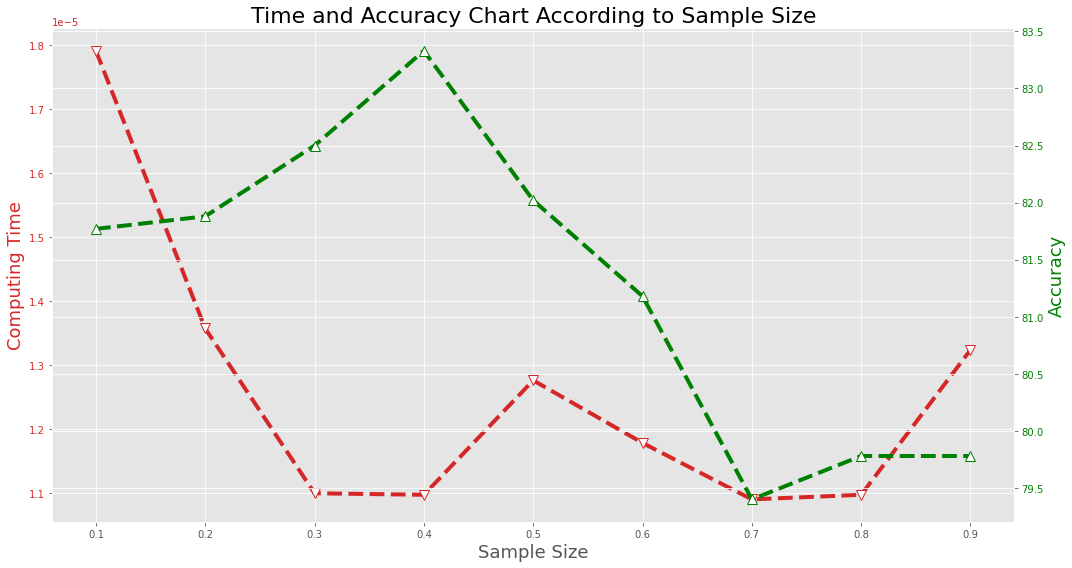

In [94]:
sample_size_time()

### Before the pass Conclusion Section we will compare all 5 models.

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR: 0.794569 (0.032801)
LDA: 0.793471 (0.032363)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.781248 (0.049400)
DECTREE: 0.815918 (0.033874)
NB: 0.810312 (0.032806)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


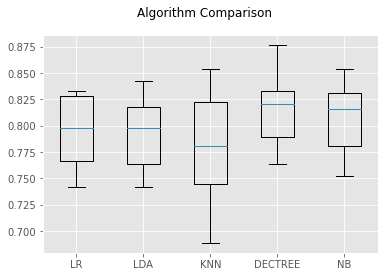

In [95]:
# Compare Algorithms

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DECTREE', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# evaluate each model in turn

scoring = 'accuracy'
results = []
names = []
for name, model in models:

    kfold = model_selection.KFold(n_splits=10, random_state=1, shuffle = False)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

> According to the average accuracy rate and standard deviation, we observe that is  our best model as Decision Tree.

<a id='conclusion'></a>
## Conclusion and Final Comments